# Transfer learning: classifying food items

_Fraida Fund_


* Name: Ziyi Liang
* Net ID: zl5604

This week, we practiced using transfer learning to classify hand shapes as rock, paper, or scissors.

But that was a relatively easy problem. In this notebook, we'll work on classifying photographs of food items into 11 classes: bread, dairy product, dessert, egg, fried food, meat, noodles/pasta, rice, seafood, soup, and vegetable/fruit.

This is a more challenging problem, because there is a lot of intra-class variability (e.g. different fruits and vegetables don't have a lot in common) and also some inter-class similarity (e.g. a bowl of rice can look similar to a bown of pasta).

To see what we mean by these, let's look at some examples of food photographs from the dataset that we'll work with.



Note: you can refer to this week's demo notebook for a closely related example.

Note: you may want to change the notebook's runtime type to GPU, for faster model training.


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

import tensorflow.keras.backend as K
import tensorflow as tf

## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [29]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [30]:
!mkdir -p /content/Food-11
%cd /content/Food-11
!gdown https://drive.google.com/uc?id=1dt3CD3ICdLbTf80sNJ25TPBDKu_qyCnq

[WinError 3] 系统找不到指定的路径。: '/content/Food-11'
D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11


�����﷨����ȷ��
'gdown' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [31]:
!unzip Food-11.zip

'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [32]:
%cd ./content

D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11\content


Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [33]:
# Some codes are modified to be able to run on Windows and make use of hardware acceleration

root_dir = r"D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11"
training_dir = "Food-11/training/"
validation_dir = "Food-11/validation/"
evaluation_dir = "Food-11/evaluation/"
num_classes = len(classes)

In [34]:
# training_dir = "Food-11/training/"
# training_images = os.listdir(training_dir)
# training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [35]:
# validation_dir = "Food-11/validation/"
# validation_images = os.listdir(validation_dir)
# validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [36]:
# evaluation_dir = "Food-11/evaluation/"
# evaluation_images = os.listdir(evaluation_dir)
# evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

Let's look at a few random training samples:

In [37]:
# num_classes = len(classes)
# samples_per_class = 4
# figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
# for cls_idx, cls in enumerate(classes):
#   idxs = np.flatnonzero(training_labels == cls_idx)
#   idxs = np.random.choice(idxs, samples_per_class, replace=False)
#   for i, idx in enumerate(idxs):
#     plt_idx = i * num_classes + cls_idx + 1
#     plt.subplot(samples_per_class, num_classes, plt_idx)
#     im = Image.open(training_dir + training_images[idx])
#     plt.imshow(im)
#     plt.axis('off')
#     if i == 0:
#       plt.title(cls)
# plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once.

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [38]:
# %cd $root_dir
# %cd ./content/Food-11/training/

# # loop over classes
# for i in range(len(classes)):
#   # make a directory for this class inside Food-11/training
#   try:
#     os.mkdir("class_%02d" % i)
#   except FileExistsError:
#     pass
#   # get list of files inside Food-11/training that have this class label
#   files = [f for f in os.listdir('.') if f.startswith("%d_" % i)]
#   # files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
#   # move each file to the subdirectory for the class
#   for f in files:
#     shutil.move(f, "class_%02d/" % i)

In [39]:
# %cd $root_dir
# %cd ./content/Food-11/validation/

# for i in range(len(classes)):
#   try:
#     os.mkdir("class_%02d" % i)
#   except FileExistsError:
#     pass
#   files = [f for f in os.listdir('.') if f.startswith("%d_" % i)]
#   # files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
#   for f in files:
#     shutil.move(f, "class_%02d/" % i)

In [40]:
# %cd $root_dir
# %cd ./content/Food-11/evaluation/

# for i in range(len(classes)):
#   try:
#     os.mkdir("class_%02d" % i)
#   except FileExistsError:
#     pass
#   files = [f for f in os.listdir('.') if f.startswith("%d_" % i)]
#   # files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
#   for f in files:
#     shutil.move(f, "class_%02d/" % i)

In [41]:
# go back to default working directory
# %cd /content

Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters, or you can keep them. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [42]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE=32
INPUT_IMG_SIZE = 224

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis.

In [43]:
# TODO 2 (optional) - design choices on image transformations for data augmentation
%cd $root_dir

# def gaussian_noise(np_arr):
#     noise = tf.random.normal(shape=tf.shape(np_arr), mean=0.0, stddev=1.0, dtype=tf.float32)
#     return tf.add(np_arr, noise)

def gaussian_noise(np_arr):
    noise = np.random.normal(loc=0.0, scale=1.0, size=np_arr.shape)
    return np_arr + noise

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,          # rescales so each pixel is in 0-1 range
	rotation_range=90,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    vertical_flip=True,
    # zca_whitening=True,
    channel_shift_range=0.1,
    # preprocessing_function=gaussian_noise,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	os.getcwd()+'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')
# training_gen = training_aug.flow_from_directory(
# 	'/content/' + training_dir,
# 	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
# 	color_mode="rgb",
# 	shuffle=True,
# 	batch_size=BATCH_SIZE,
#   class_mode='sparse')

D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11
Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [44]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We also set up the validation and evaluation (test) sets in a similar manner:

In [45]:
%cd $root_dir

validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	os.getcwd()+'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')
# validation_gen = validation_aug.flow_from_directory(
# 	'/content/' + validation_dir,
# 	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
# 	color_mode="rgb",
# 	shuffle=True,
# 	batch_size=BATCH_SIZE,
#   class_mode='sparse')

D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11
Found 3430 images belonging to 11 classes.


Don't shuffle the evaluation set:

In [46]:
%cd $root_dir

evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	os.getcwd()+'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

# evaluation_gen = evaluation_aug.flow_from_directory(
# 	'/content/' + evaluation_dir,
# 	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
# 	color_mode="rgb",
# 	shuffle=False,
# 	batch_size=BATCH_SIZE,
#   class_mode='sparse')

D:\文档\NYU Classes\2023 Fall\ECE-GY 6143 Machine Learning\Lab 11
Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change that - you may use any model that you think will have good results.

In [47]:
# TODO 3 (optional) - design choice on base model

# base_model = tf.keras.applications.VGG16(
#   input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
#   include_top=False,
#   pooling='avg'
# )
base_model = tf.keras.applications.InceptionResNetV2(
    input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
    include_top=False,
    pooling='avg'
)

In [48]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [49]:
# TODO 4 (required) - prepare model with new classification head
base_model.trainable=False
model = tf.keras.models.Sequential()
# add to your model here...

model.add(base_model)
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

Then, print a model summary:

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 11)                16907     
                                                                 
Total params: 54,353,643
Trainable params: 16,907
Non-trainable params: 54,336,736
_________________________________________________________________


(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric.

In [51]:
# TODO 5 (required) - design training parameters, and compile

# model.compile(...)
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # 0.001 0.002 0.004 0.008 0.016
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

(You can refer to this week's demo notebook for an example.)

In [52]:
from tensorflow.keras import callbacks

class TrainStats(callbacks.Callback):

    def __init__(self):
        self.best_train_acc = 0.0
        self.best_train_loss = 0.0
        self.best_val_acc = 0.0
        self.best_val_loss = 0.0
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_epoch = epoch

        train_acc = logs.get("accuracy")
        if train_acc > self.best_train_acc:
            self.best_train_acc = train_acc  

        val_loss = logs.get("val_loss")
        if val_loss > self.best_val_loss:
            self.best_val_loss = val_loss
            
        train_loss = logs.get("loss")
        if train_loss > self.best_train_loss:
            self.best_train_acc = train_loss

        print(f"""Best Stats:
              Train acc: {self.best_train_acc:.4f}\tTrain loss: {self.best_train_loss:.4f}
              Val acc:   {self.best_val_acc:.4f}\tVal loss:   {self.best_val_loss:.4f}
              Epoch: {self.best_epoch}\tLearning rate:{self.model.optimizer.lr.numpy():.4e}""")

        # if conditions are met..
        # self.model.stop_training = True

In [53]:
checkpoint_path = "checkpoint/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="./backup", delete_checkpoint=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           min_delta=0.00005,
                                                           patience=10,
                                                           restore_best_weights=True,
                                                           verbose=1)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return lr * np.exp(-0.05)
    else:
        return lr * np.exp(-0.025)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [54]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n
# n_epochs = ...
# hist = model.fit(...)
n_epochs = 200
K.clear_session()
hist = model.fit(x=training_gen, 
                 epochs=n_epochs,
                 validation_data=validation_gen, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[cp_callback, 
                            early_stopping_callback,
                            lr_scheduler,
                            ])
# hist = model.fit(x=training_gen, epochs=n_epochs, batch_size=BATCH_SIZE)

Epoch 1/200
309/309 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.6499
Epoch 1: saving model to checkpoint\cp_0001.ckpt
309/309 [==============================] - 101s 313ms/step - loss: 1.0527 - accuracy: 0.6499 - val_loss: 0.6845 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 2/200
309/309 [==============================] - ETA: 0s - loss: 0.7880 - accuracy: 0.7372
Epoch 2: saving model to checkpoint\cp_0002.ckpt
309/309 [==============================] - 85s 273ms/step - loss: 0.7880 - accuracy: 0.7372 - val_loss: 0.6497 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 3/200
309/309 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.7563
Epoch 3: saving model to checkpoint\cp_0003.ckpt
309/309 [==============================] - 84s 272ms/step - loss: 0.7417 - accuracy: 0.7563 - val_loss: 0.6601 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 4/200
309/309 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7691
Epoch 4: saving model t

In [55]:
model.save('ggn_basic.keras')
np.save('ggn_hist.npy',hist.history) # in case of kernel crashing

Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

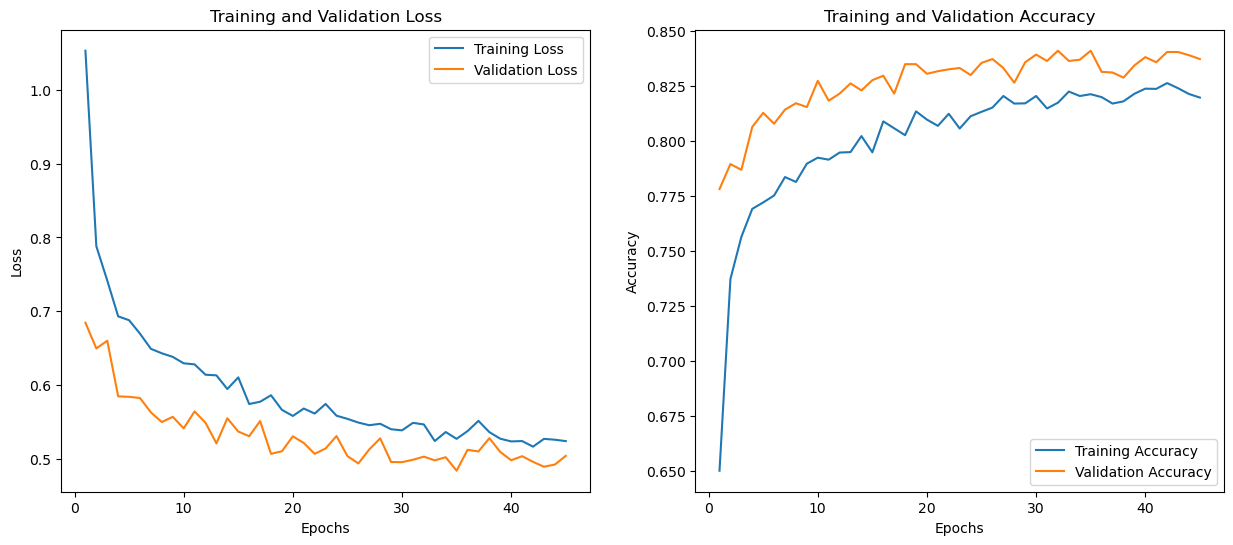

In [56]:
# TODO 7 (required) - plot training history
# Accessing training and validation loss values from history
try:
    tr_loss = hist.history['loss']
    tr_acc = hist.history['accuracy']
    val_loss = hist.history['val_loss']
    val_acc = hist.history['val_accuracy']
except NameError:
    history_loaded=np.load('ggn_hist.npy',allow_pickle='TRUE').item()
    tr_loss = history_loaded['loss']
    tr_acc = history_loaded['accuracy']
    val_loss = history_loaded['val_loss']
    val_acc = history_loaded['val_accuracy']

epochs = range(1, len(tr_loss) + 1)

# Visualizing training and validation loss
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, tr_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [28]:
# Load model
model = tf.keras.models.load_model('ggn_basic.keras')

In [57]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [58]:
# TODO 8 (optional) - you can decide how many layers to unfreeze

for layer in base_model.layers[:-19]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [59]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x000002B5D156CCD0>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002BA34F65400>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002B98AB67B50>: False
<keras.layers.core.activation.Activation object at 0x000002BA34F65D90>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002BA34F8A730>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002BA34F8AF10>: False
<keras.layers.core.activation.Activation object at 0x000002BA34F8A340>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002BA34F7CDF0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002BA34F8FF40>: False
<keras.layers.core.activation.Activation object at 0x000002BA34F7C040>: False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002BA34F7A790>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000

Also, the model summary should now show more trainable parameters:

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 11)                16907     
                                                                 
Total params: 54,353,643
Trainable params: 5,247,883
Non-trainable params: 49,105,760
_________________________________________________________________


Re-compile your model. Don't forget to use a smaller learning rate for fine-tuning! We don't want to make major changes to the last feature extraction layers, we just want to adjust them a little bit.

In [61]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning
try:
    first_lr = hist.history['lr'][0]
    last_lr = hist.history['lr'][-1]
except NameError:
    first_lr = history_loaded['lr'][0]
    last_lr = history_loaded['lr'][-1]
ft_lr = first_lr * 0.02
print("Learning rate decay from", first_lr, "to", last_lr)
print("Fine tune learning rate:", ft_lr)
# model.compile(...)
opt = tf.keras.optimizers.Adam(learning_rate=ft_lr)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
print(model.optimizer.lr.numpy())

Learning rate decay from 0.001 to 0.0003246525
Fine tune learning rate: 2.0000000949949027e-05
2.0000000949949027e-05


Fit your model (with some newly unfrozen layers) for some more epochs.

In [62]:
ft_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           min_delta=0.00001,
                                                           patience=10,
                                                           restore_best_weights=True)
def ft_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return lr * np.exp(-0.05)
    else:
        return lr * np.exp(-0.025)
ft_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(ft_scheduler, verbose=0)

In [63]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs_fine = ...
# hist_fine = model.fit(...)
n_epochs_fine = 200
# FT_BATCH_SIZE = 0.75 * BATCH_SIZE
hist_fine = model.fit(x=training_gen, 
                    epochs=n_epochs_fine,
                    validation_data=validation_gen, 
                    batch_size=BATCH_SIZE/2, 
                    callbacks=[cp_callback, 
                              #  TrainStats(),
                               ft_early_stopping_callback,
                               ft_lr_scheduler,
                               
                            #    backup_callback
                               ])

Epoch 1/200
309/309 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.7963
Epoch 1: saving model to checkpoint\cp_0001.ckpt
309/309 [==============================] - 96s 294ms/step - loss: 0.6348 - accuracy: 0.7963 - val_loss: 0.4833 - val_accuracy: 0.8434 - lr: 2.0000e-05
Epoch 2/200
309/309 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8285
Epoch 2: saving model to checkpoint\cp_0002.ckpt
309/309 [==============================] - 88s 285ms/step - loss: 0.5231 - accuracy: 0.8285 - val_loss: 0.4548 - val_accuracy: 0.8507 - lr: 2.0000e-05
Epoch 3/200
309/309 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.8357
Epoch 3: saving model to checkpoint\cp_0003.ckpt
309/309 [==============================] - 91s 296ms/step - loss: 0.4933 - accuracy: 0.8357 - val_loss: 0.4412 - val_accuracy: 0.8531 - lr: 2.0000e-05
Epoch 4/200
309/309 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8462
Epoch 4: sav

In [64]:
model.save('ggn_fine_tune.keras')
np.save('ggn_hist_fine.npy',hist_fine.history) # in case of crashing

Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist_fine = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

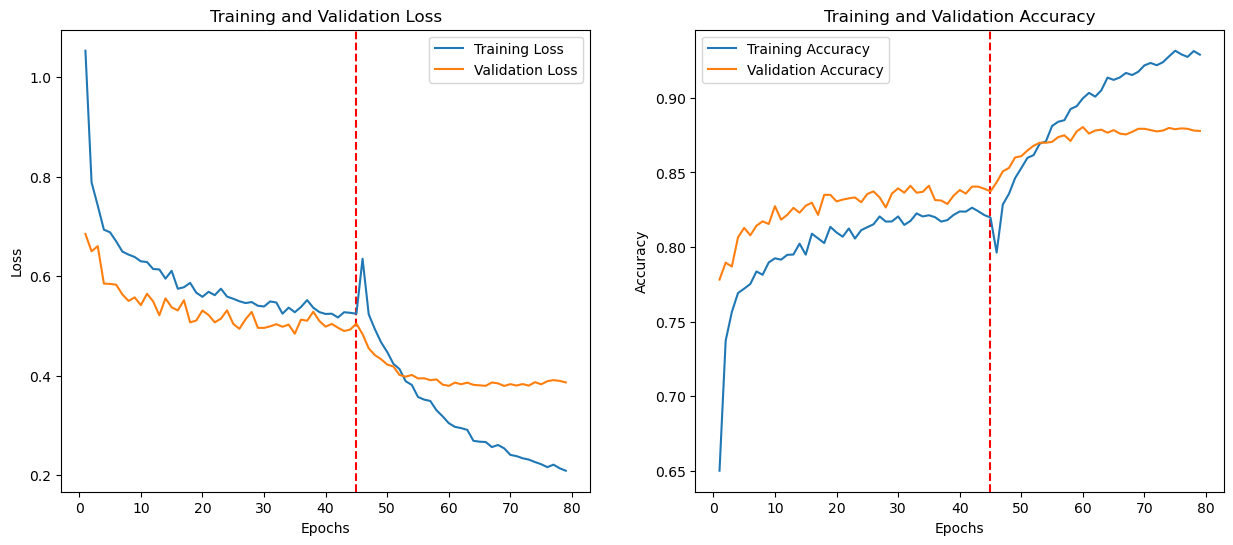

In [65]:
# TODO 11 (required) - plot training history
try:
    tr_loss = hist.history['loss']
    tr_acc = hist.history['accuracy']
    val_loss = hist.history['val_loss']
    val_acc = hist.history['val_accuracy']
except NameError:
    history_loaded=np.load('ggn_hist.npy',allow_pickle='TRUE').item()
    tr_loss = history_loaded['loss']
    tr_acc = history_loaded['accuracy']
    val_loss = history_loaded['val_loss']
    val_acc = history_loaded['val_accuracy']
border = len(tr_loss)
ft_tr_loss = tr_loss + hist_fine.history['loss']
ft_tr_acc = tr_acc + hist_fine.history['accuracy']
ft_val_loss = val_loss + hist_fine.history['val_loss']
ft_val_acc = val_acc + hist_fine.history['val_accuracy']
epochs = range(1, len(ft_tr_loss) + 1)

# Visualizing training and validation loss
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.axvline(x=border, color='red', linestyle='--', label='')
plt.plot(epochs, ft_tr_loss, label='Training Loss')
plt.plot(epochs, ft_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.axvline(x=border, color='red', linestyle='--', label='')
plt.plot(epochs, ft_tr_acc, label='Training Accuracy')
plt.plot(epochs, ft_val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate model performance


Once you have finished training your model, use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [66]:
K.clear_session()
model = tf.keras.models.load_model('model.keras')
model.evaluate(evaluation_gen)
# K.clear_session()
# model_old = tf.keras.models.load_model('model.keras')
# model.evaluate(evaluation_gen)

105/105 [==============================] - 12s 96ms/step - loss: 0.3091 - accuracy: 0.8963


[0.3091265857219696, 0.8963250517845154]

We can also create a confusion matrix, to see which which classes are most often confused with one another.

In [67]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

105/105 [==============================] - 11s 88ms/step


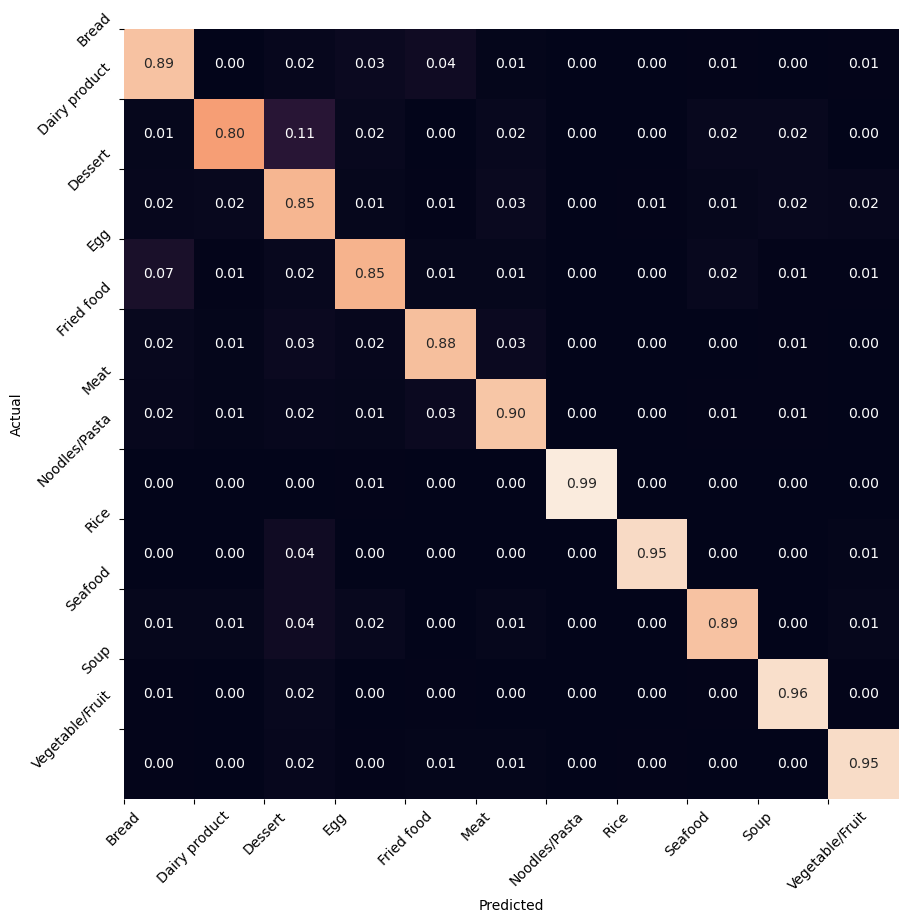

In [68]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11), labels=classes, rotation=45)

## Save your model

Use the following cell to save your model:

In [69]:
model.save("model.keras")

Then, download it for later use.

In [45]:
from google.colab import files
files.download('model.keras')

ModuleNotFoundError: No module named 'google.colab'

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class.


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

(1920, 1080)
(1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


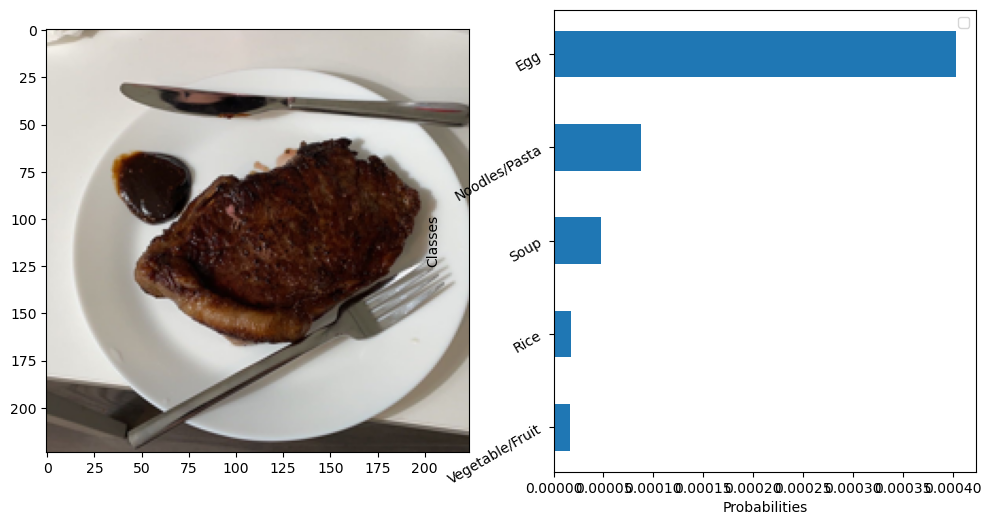

In [70]:
# TODO 12 (required) - show example of model use on a new image
img = Image.open("custom_image_meat.jpg")
print(img.size)
width, height = img.size[0], img.size[1]
if height > width:
    width, height = height, width
left = width // 2 - height // 2
right = width // 2 + height // 2
upper = 0
lower = height

cropped_img = img.crop((left, upper, right, lower))
resize_img = cropped_img.resize([INPUT_IMG_SIZE, INPUT_IMG_SIZE])
img_arr = np.reshape(np.array(resize_img) / 255.0, (1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3))
print(img_arr.shape)
K.clear_session()
model = tf.keras.models.load_model('model.keras')
y_pred_prob_custom = model.predict(img_arr)
y_pred_custom = np.argmax(y_pred_prob_custom, axis=1)
sorted_class_indexes = np.argsort(y_pred_prob_custom)[0][:5]
sorted_class_prob = np.sort(y_pred_prob_custom, axis=1)[0][:5]
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(resize_img)

plt.subplot(1,2,2)
bar_wid = 0.5
ind = np.arange(len(classes))
plt.yticks(rotation=30)
plt.barh(classes[list(sorted_class_indexes)], sorted_class_prob, bar_wid)

plt.ylabel("Classes")
plt.xlabel("Probabilities")
plt.legend()

plt.show()

## Describe your model - TODO 13 (required)

In the following cell, describe your final model and your results, by answering the following questions.

* What base model did you use? How many parameters does this base model have?
* Describe the specific transformations you used to create an augmented data set.
* For how many epochs did you train your classification head, and with what optimizer, learning rate, and batch size? What was the validation accuracy at the end of this training stage?
* Which layers did you un-freeze for fine-tuning, how many epochs did you fine-tune for, and what optimizer, learning rate, and batch size did you use for fine-tuning? What was the validation accuracy at the end of this training stage?
* What was your final accuracy on the evaluation set?
* Did your model correctly predict the class of your custom test image?

* I used the Inception Resnetv2. The model has 54,336,736 paramemters.
* The augmentations used are the default ones provided by Professor Fund, 
	Plus three additional augmentations: (Explanation for these augmentations quoted from docstring of ` tf.keras.preprocessing.image.ImageDataGenerator`)
    * `rescale=1.0/255`: Rescale all pixels into [0, 1] range;
    * `rotation_range=1`: degree range for random rotations;
	* `zoom_range=0.1`：range for random zoom;
	* `width_shift_range=0.1`：fraction of total width shifted horizontally;
	* `height_shift_range=0.1`：fraction of total height shifted vertically;
	* `shear_range=0.1`：the intensity of image being sheared;
	* `horizontal_flip=True`：image is filpped horizontally randomly;
	* `fill_mode="nearest"`: points outside the boundaries of the input are filled with nearest mode;
	* `rotation_range=90`: the image is rotated randomly up to 90 degree;
	* `brightness_range=(0.8, 1.2)`: the RGB value is multiplied by value randomly selected from the range;
	* `channel_shift_range=0.1`: the channel is randomly shifted.

* I trained the classification head 45 epochs, with Adam optimizer, learning rate of 0.001, amd batch size of 32. The validation accuracy at the end of this training stage is 0.8373.
* There is one stage of un-freezing:
	1. Last 19 layers un-frozen: 
		- The last 19 to 5 layers are the last residual inception block. Unfreezing this block helps the model learn more detailed features;
		- epoch: 34, optimizer: Adam, learning rate: 2e-05, batch size: 16, validation accuracy: 0.8778
* The final accuracy is 0.8963
* My model does not predict the calss of my custom test image correctly.
